In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import pickle

In [2]:
import code.form_trajectories

In [3]:

list_of_files = []
subjectID = []
activityIDdict = { }
colNames = []
IMUhand = []
IMUchest = []
IMUankle = []
columns = []

list_of_files, subjectID, activityIDdict, colNames, IMUhand, IMUchest, IMUankle, columns = code.form_trajectories.load_indices()
len(columns)

54

In [4]:
dataCollection = code.form_trajectories.formDataFrame(list_of_files, columns)
dataCollection.head(10)

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1
5,8.43,0,NaN,30.0,2.29959,8.82929,3.54710,2.26132,8.65762,3.77788,...,-0.016024,0.001050,-60.2954,-38.8778,-58.3977,1.0,0.0,0.0,0.0,1
6,8.44,0,NaN,30.0,2.33738,8.82900,3.54767,2.27703,8.77828,3.73230,...,-0.053934,0.015594,-60.6307,-38.8676,-58.2711,1.0,0.0,0.0,0.0,1
7,8.45,0,NaN,30.0,2.37142,9.05500,3.39347,2.39786,8.89814,3.64131,...,-0.039937,-0.000785,-60.5171,-38.9819,-58.2733,1.0,0.0,0.0,0.0,1
8,8.46,0,NaN,30.0,2.33951,9.13251,3.54668,2.44371,8.98841,3.62596,...,-0.010042,0.017701,-61.2916,-39.6182,-58.1499,1.0,0.0,0.0,0.0,1
9,8.47,0,NaN,30.0,2.25966,9.09415,3.43015,2.42877,9.01871,3.61081,...,-0.013923,0.014498,-60.8509,-39.0821,-58.1478,1.0,0.0,0.0,0.0,1


In [5]:
selected_sensors = ['ankleGyro1', 'ankleGyro2', 'ankleGyro3']
selected_features = ['activityID'] + selected_sensors + ['subject_id']
activityID = [3, 4, 5, 6]
dataCol = code.form_trajectories.dataCleaning(dataCollection, selected_features, activityID, activityIDdict)
dataCol.reset_index(drop=True, inplace=True)

In [8]:
all_velocities, targets = code.form_trajectories.set_trajectory_target(subjectID, activityID, selected_sensors, dataCol)

In [9]:
code.form_trajectories.form_all_trajectories(all_velocities, 'experiment1')

100%|██████████| 1372/1372 [00:01<00:00, 1004.68it/s]


In [ ]:
import code.trajectories_proccesing

In [10]:
X, y = code.trajectories_proccesing.get_data(0, 1299)

In [ ]:
random_state = 124

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

In [ ]:
pca_instance = PCA(17)

X_train_transformed = pca_instance.fit_transform(X_train)
X_test_transformed = pca_instance.transform(X_test)

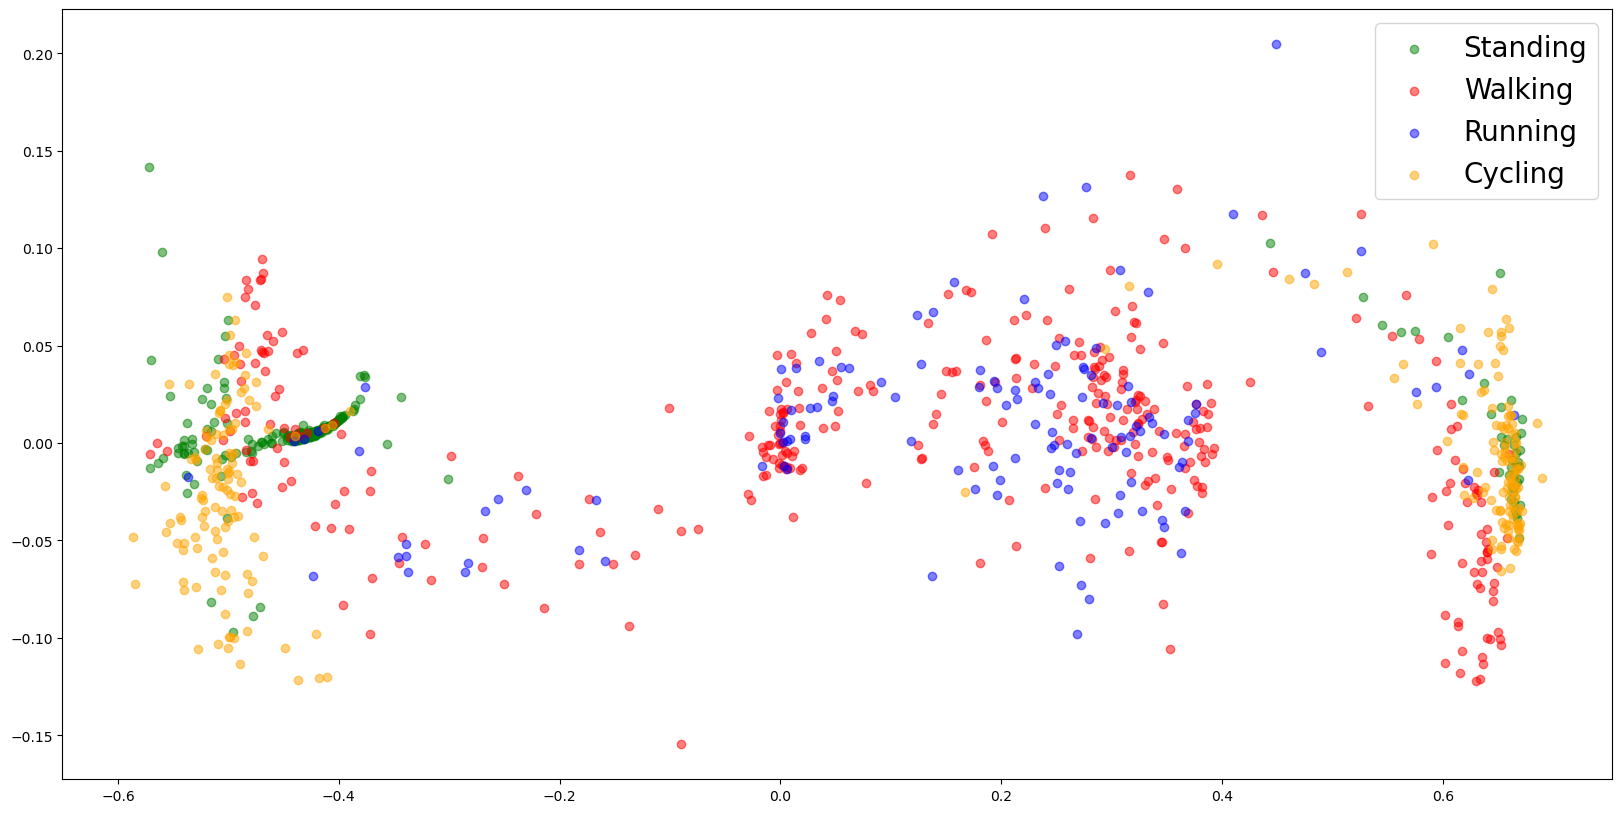

In [ ]:
plt.figure(figsize = (20, 10))

X_standing = X_train_transformed[np.where(y_train == 3)]
X_walking = X_train_transformed[np.where(y_train == 4)]
X_running = X_train_transformed[np.where(y_train == 5)]
X_cycling = X_train_transformed[np.where(y_train == 6)]

X_standing_test = X_test_transformed[np.where(y_test == 3)]
X_walking_test = X_test_transformed[np.where(y_test == 4)]
X_running_test = X_test_transformed[np.where(y_test == 5)]
X_cycling_test = X_test_transformed[np.where(y_test == 6)]

plt.scatter(X_standing[:, 1], X_standing[:, 16], alpha = 0.5, color = "green", label = "Standing")
plt.scatter(X_walking[:, 1], X_walking[:, 16], alpha = 0.5, color = 'red', label = "Walking")
plt.scatter(X_running[:, 1], X_running[:, 16], alpha = 0.5, color = 'blue', label = "Running")
plt.scatter(X_cycling[:, 1], X_cycling[:, 16], alpha = 0.5, color = 'orange', label = "Cycling")

#plt.scatter(X_standing_test[:, 0], X_standing_test[:, 5], alpha = 0.5, color = "green")
#plt.scatter(X_walking_test[:, 0], X_walking_test[:, 5], alpha = 0.5, color = 'red')
#plt.scatter(X_running_test[:, 0], X_running_test[:, 5], alpha = 0.5, color = 'blue')
#plt.scatter(X_cycling_test[:, 0], X_cycling_test[:, 5], alpha = 0.5, color = 'orange')

plt.legend(fontsize = 20)
plt.savefig(Path("code/figures", "Data.png"))
plt.show()

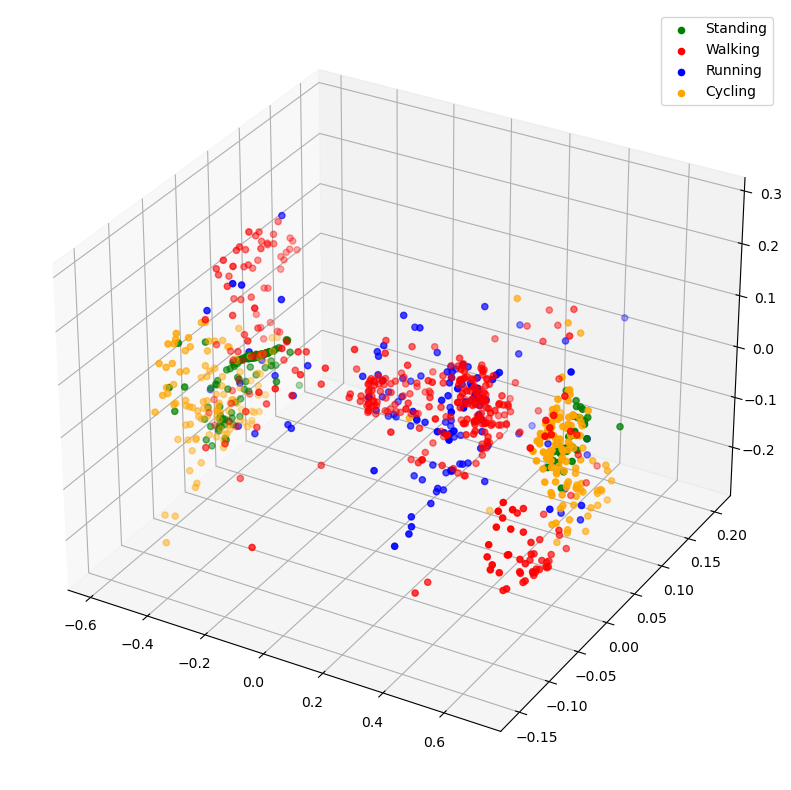

In [ ]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection='3d')

X_standing = X_train_transformed[np.where(y_train == 3)]
X_walking = X_train_transformed[np.where(y_train == 4)]
X_running = X_train_transformed[np.where(y_train == 5)]
X_cycling = X_train_transformed[np.where(y_train == 6)]

X_standing_test = X_test_transformed[np.where(y_test == 3)]
X_walking_test = X_test_transformed[np.where(y_test == 4)]
X_running_test = X_test_transformed[np.where(y_test == 5)]
X_cycling_test = X_test_transformed[np.where(y_test == 6)]

ax.scatter(X_standing[:, 1], X_standing[:, 16], X_standing[:, 6], color="green", label = "Standing")
ax.scatter(X_walking[:, 1], X_walking[:, 16], X_walking[:, 6], color="red", label = "Walking")
ax.scatter(X_running[:, 1], X_running[:, 16], X_running[:, 6], color="blue", label = "Running")
ax.scatter(X_cycling[:, 1], X_cycling[:, 16], X_cycling[:, 6], color="orange", label = "Cycling")

#ax.scatter(X_standing_test[:, 0], X_standing_test[:, 1], X_standing_test[:, 5], alpha = 0.5, color = "green")
#ax.scatter(X_walking_test[:, 0], X_walking_test[:, 1], X_walking_test[:, 5], alpha = 0.5, color = 'red')
#ax.scatter(X_running_test[:, 0], X_running_test[:, 1], X_running_test[:, 5], alpha = 0.5, color = 'blue')
#ax.scatter(X_cycling_test[:, 0], X_cycling_test[:, 1], X_cycling_test[:, 5], alpha = 0.5, color = 'orange')

plt.legend(fontsize = 10)
plt.savefig(Path("code/figures", "Data_3D.png"))
plt.show()

In [ ]:
pca_instance = PCA(20)

X_train_transformed = pca_instance.fit_transform(X_train)
X_test_transformed = pca_instance.transform(X_test)

In [ ]:
regression = LogisticRegression(C=1.0)
regression.fit(X_train_transformed, y_train)

y_pred = regression.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [ ]:
gpc = GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=random_state)
gpc.fit(X_train_transformed, y_train)

y_pred = gpc.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [ ]:
forest = RandomForestClassifier(n_estimators=1000)
forest.fit(X_train_transformed, y_train)

y_pred = forest.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

In [ ]:
print(acc_score)

0.85


In [ ]:
x = []
y_1 = []
y_2 = []
y_3 = []
for i in tqdm(range(2, 30)):
    pca_instance = PCA(i)

    X_train_transformed = pca_instance.fit_transform(X_train)
    X_test_transformed = pca_instance.transform(X_test)
    
    regression = LogisticRegression(C=1.0)
    regression.fit(X_train_transformed, y_train)
    
    gpc = GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=random_state)
    gpc.fit(X_train_transformed, y_train)
    
    forest = RandomForestClassifier(n_estimators=1000)
    forest.fit(X_train_transformed, y_train)

    y_pred_1 = regression.predict(X_test_transformed)
    acc_score_1 = accuracy_score(y_test, y_pred_1)
    y_1.append(acc_score_1)
    
    y_pred_2 = gpc.predict(X_test_transformed)
    acc_score_2 = accuracy_score(y_test, y_pred_2)
    y_2.append(acc_score_2)
    
    y_pred_3 = forest.predict(X_test_transformed)
    acc_score_3 = accuracy_score(y_test, y_pred_3)
    y_3.append(acc_score_3)
    
    x.append(i)

  4%|█▌                                          | 1/28 [00:20<09:23, 20.88s/it]


KeyboardInterrupt: 

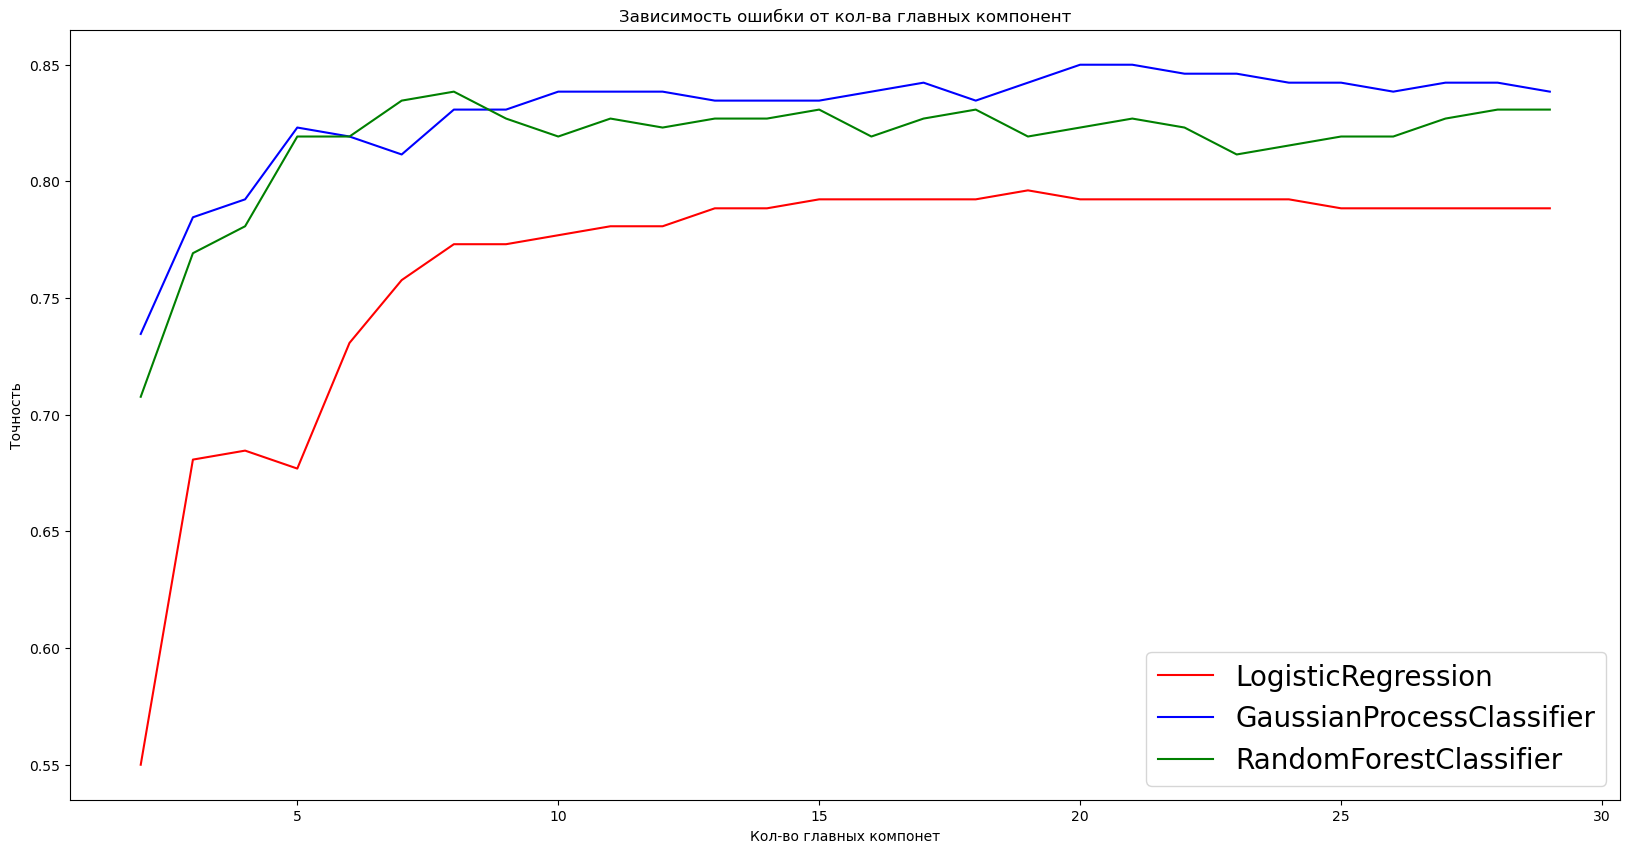

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(x, y_1, color="red", label = "LogisticRegression")
plt.plot(x, y_2, color="blue", label = "GaussianProcessClassifier")
plt.plot(x, y_3, color="green", label = "RandomForestClassifier")
plt.xlabel("Кол-во главных компонет")
plt.ylabel("Точность")
plt.title("Зависимость ошибки от количества главных компонент")
plt.legend(fontsize = 20)
plt.savefig(Path("figures", "Accuracy.png"))
plt.show()